# Что попробовал:
* удалить скоррелированные - без особого эффекта
* разные способы инпутации. Лучше всего сработала стратегия Most Frequent и KNN imputer (только он считается сильно дольше)
* добавление индикатора импутации. хорошо подняло качество
* добавление переменной "количество миссингов в строке". Не помогло
* отбор переменных с помощью регуляризации (удалить совсем бесполезные, оставить топ 10,50,100). Не помогло
* виндоризация. очень хорошо помогло по условию 3 IQR
* оверсемплинг. попробовал 3 разных подхода из библиотеки imbalanced-learn, все ухудшили качество. Видимо логистическая регресия нормально справляется с дисбалансом класса
* комбинация из индикаторов импутации и виндоризации прироста не дала.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import LocalOutlierFactor
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv("aps_failure_training_set.csv",skiprows=20,na_values="na")
df['class']=df['class'].map({'pos':1, 'neg':0})
df = df.apply(lambda col: pd.to_numeric(col, downcast = 'float'))

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: float32(171)
memory usage: 39.1 MB


In [4]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


## Посмотрим, что там с миссингами

In [5]:
(df.isna().sum()/df.shape[0]).sort_values()

class     0.000000
aa_000    0.000000
bt_000    0.002783
ck_000    0.005633
cj_000    0.005633
            ...   
cr_000    0.772150
bo_000    0.772217
bp_000    0.795667
bq_000    0.812033
br_000    0.821067
Length: 171, dtype: float64

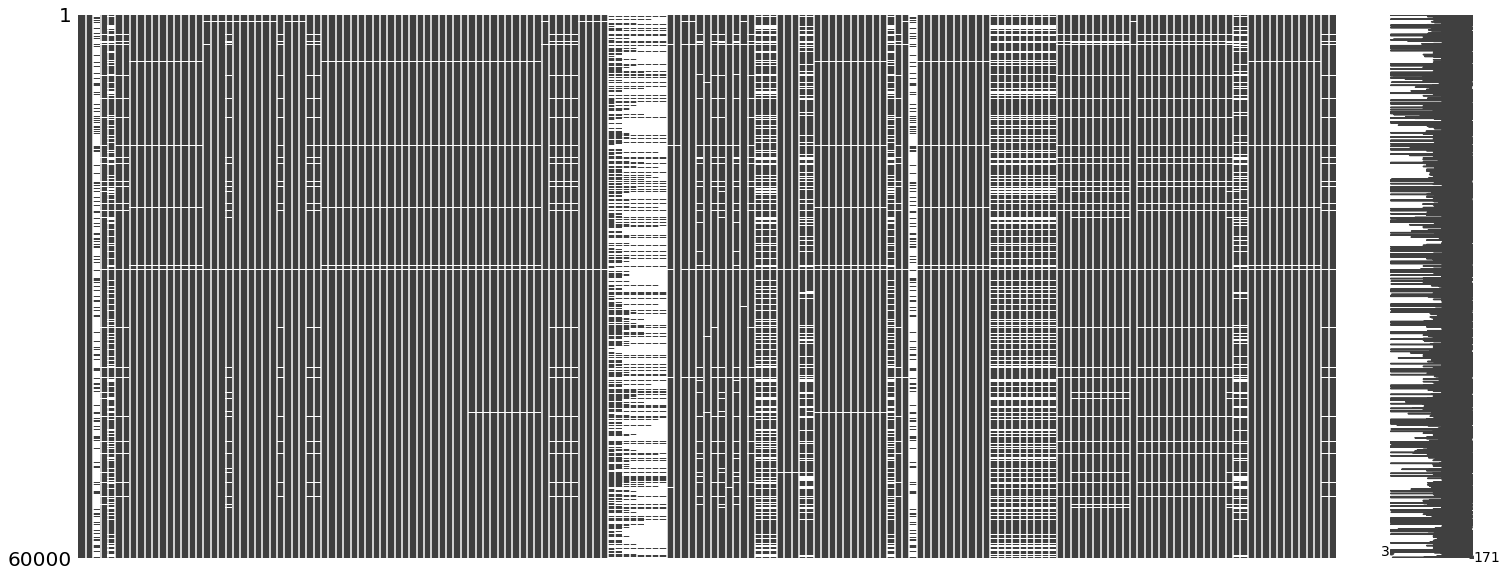

In [6]:
msno.matrix(df);

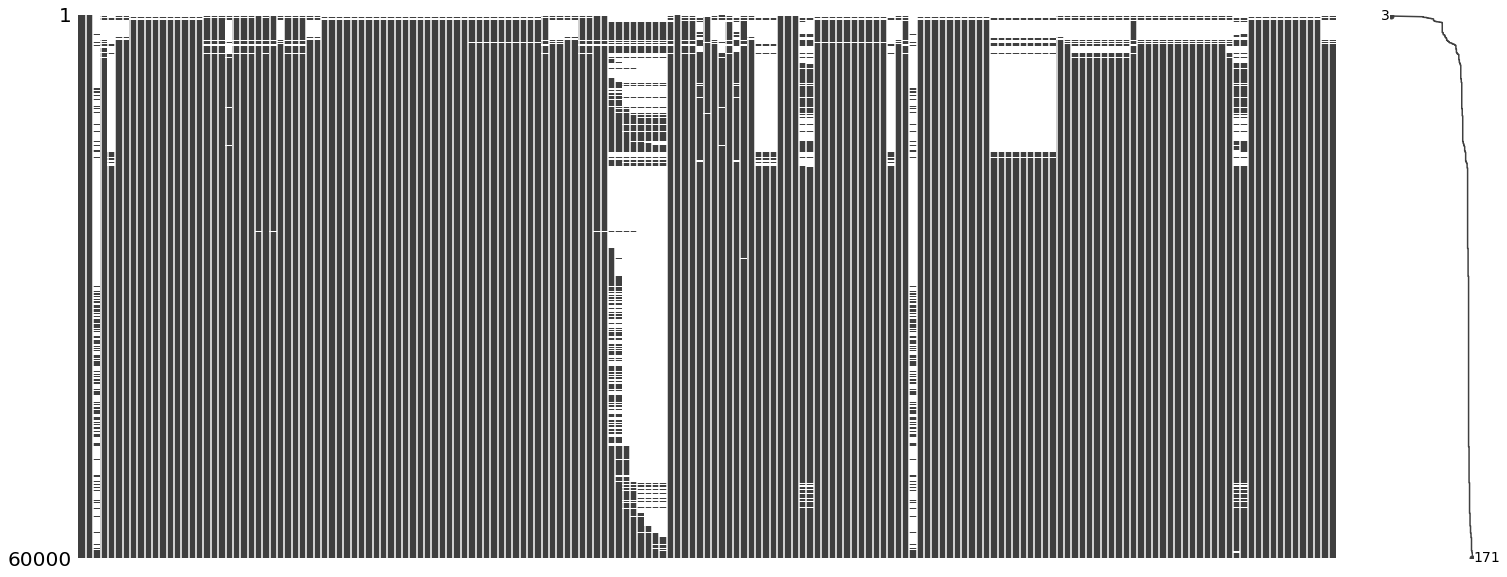

In [7]:
msno.matrix(df, sort='ascending');

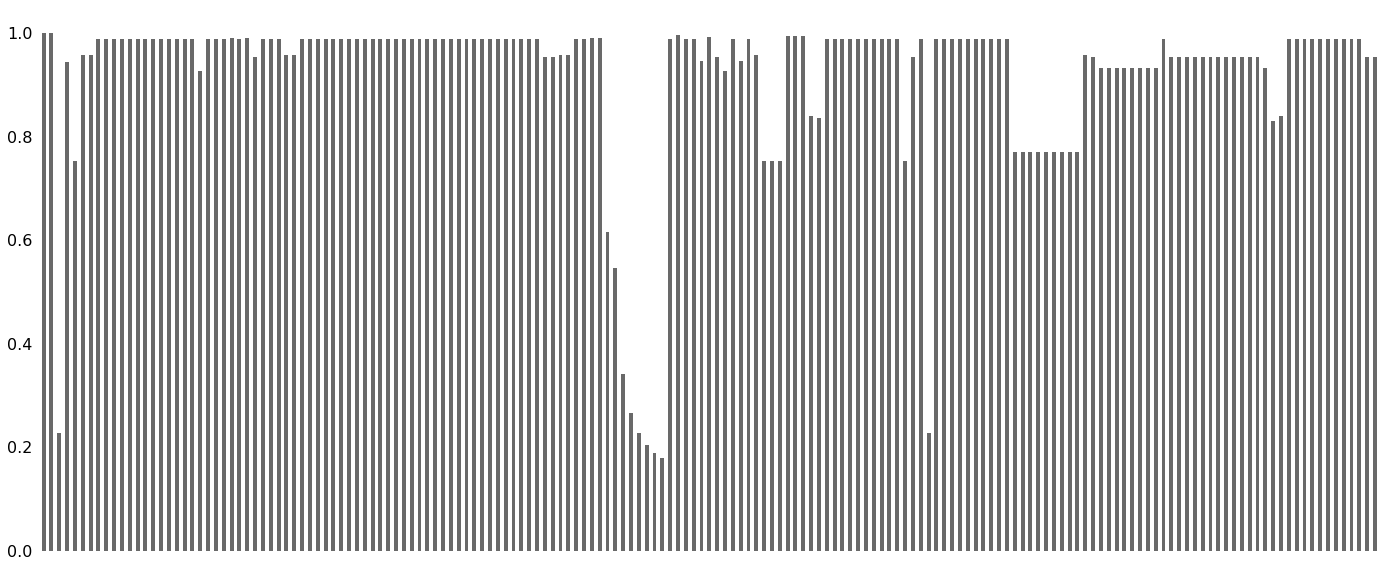

In [8]:
msno.bar(df);

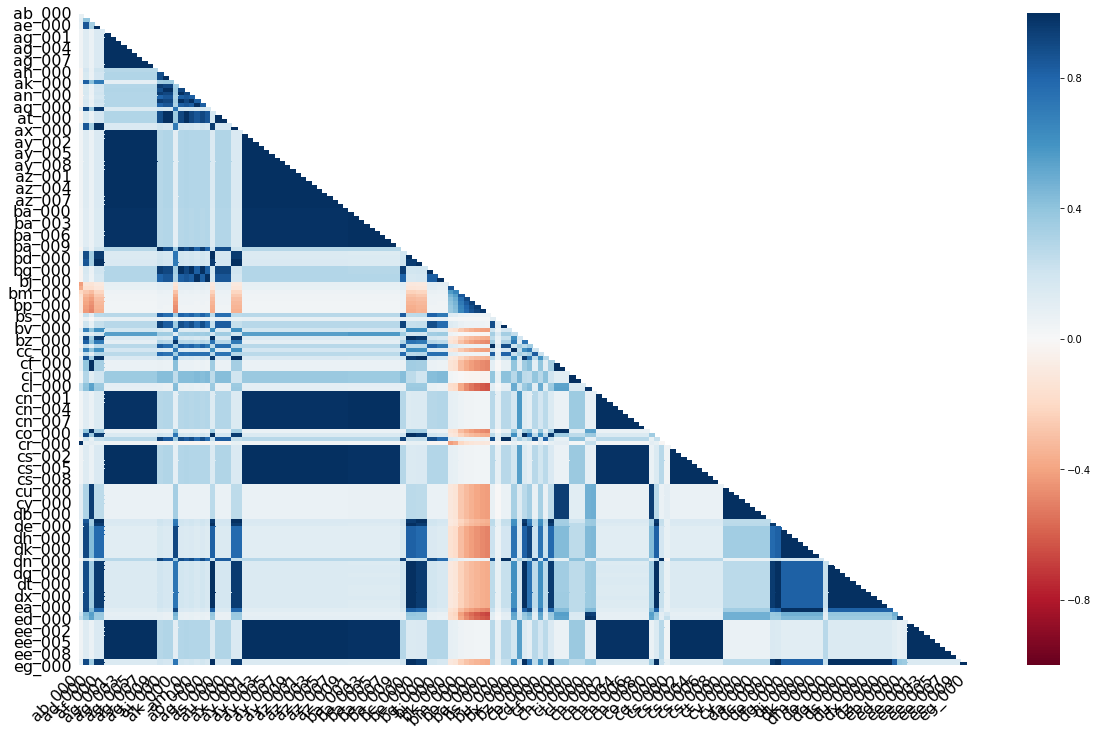

In [9]:
msno.heatmap(df, labels= False)

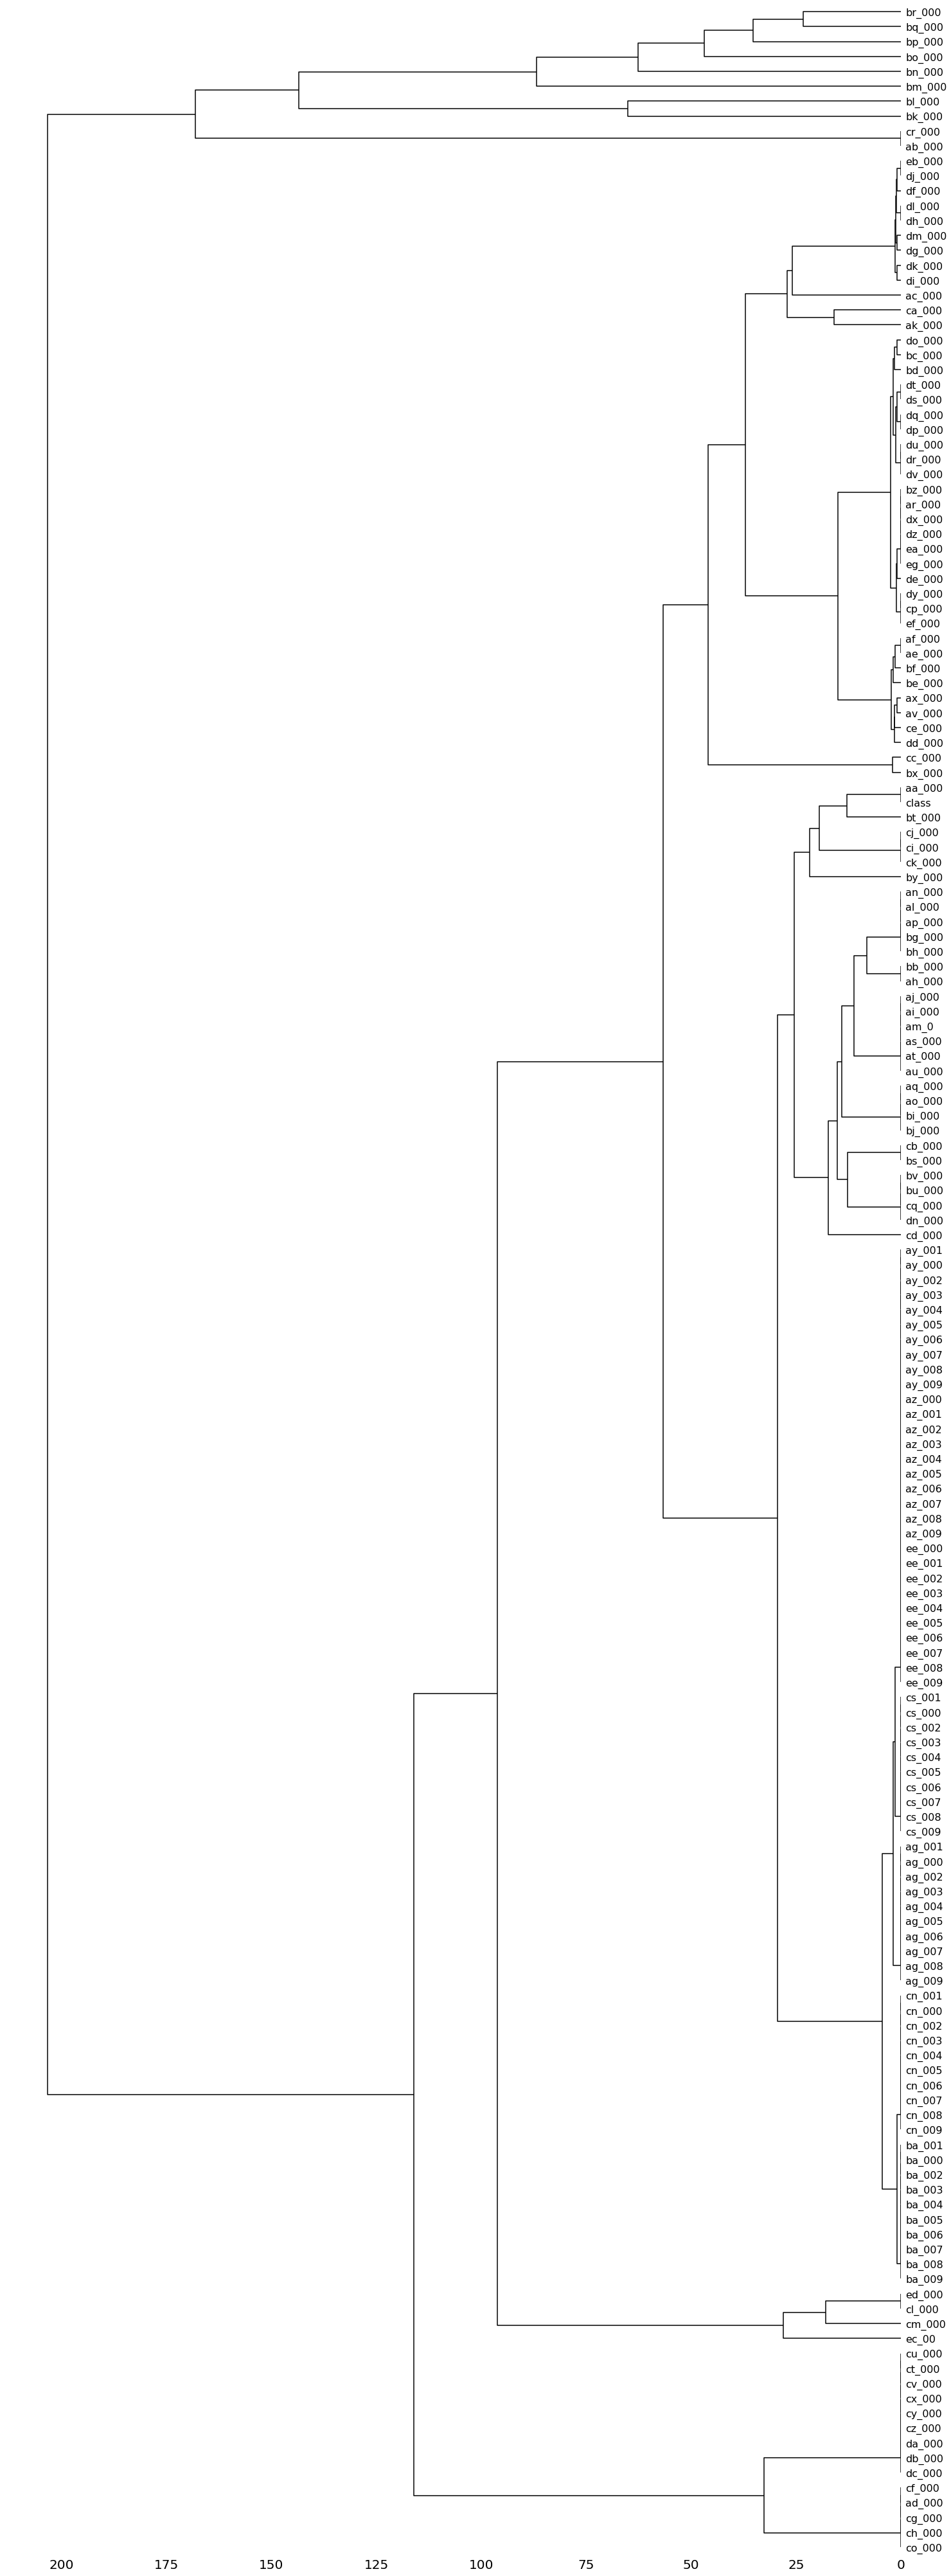

In [10]:
msno.dendrogram(df)

#### Выводы по миссингам:
пропущенных значений много, практически в каждом столбце
есть столбцы, практически полностью состоящие из пустых значений
много столбцов, заполняемость которых скоррелирована с другими столбцами

## Корреляция в данных

In [11]:
corr = df.corr()

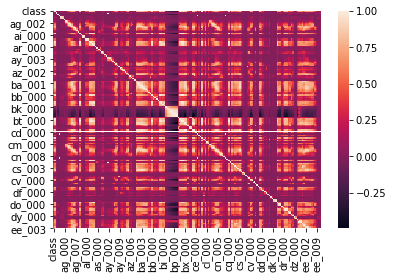

In [12]:
sns.heatmap(corr)

In [13]:
# получаем все пары признаков
pairs = corr.stack().abs().reset_index()
# оставляем уникальные наборы
pairs = pairs[pairs.level_0<pairs.level_1]
# отбираем пары с высокой степенью корреляции
pairs = pairs[pairs[0]>0.8]
to_del= pairs.level_1.unique()

# Baseline

In [14]:
def data_split_train_test(data, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['class'], axis=1),
    data['class'],
    test_size=test_size,
    stratify=data['class'],
    random_state=0)

    print("Train_shape:", X_train.shape, "Test shape:", X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [15]:
def quality_report(prediction, actual, verbose=True):
    report_str = "Accuracy: \t {:.3f}\n" +\
                 "Precision: \t {:.3f}\n" +\
                 "Recall: \t {:.3f}\n" +\
                 "f1_score: \t {:.3f}\n" +\
                 "ROC-AUC: \t {:.3f}"
    
    acc = accuracy_score(prediction, actual)
    precision = precision_score(prediction, actual)
    recall = recall_score(prediction, actual)
    f1 = f1_score(prediction, actual)
    rocauc = roc_auc_score(prediction, actual)
    
    quality_list = [acc, precision, recall, f1, rocauc]
    
    if verbose:
        print("\n=== Quality Report ===")
        print(report_str.format(
            accuracy_score(prediction, actual),
            precision_score(prediction, actual),
            recall_score(prediction, actual),
            f1_score(prediction, actual),
            roc_auc_score(prediction, actual)
        ))
        print("======================\n")
    
    return quality_list

In [16]:
def assess_data(data, df_quality, exp_name, verbose=False):
    X_train, X_test, y_train, y_test = data_split_train_test(data)
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

    model_LogR = LogisticRegression(solver="liblinear")
    model_LogR.fit(X_train_scaled, y_train)
    pred = model_LogR.predict(X_test_scaled)

    quality_list = quality_report(pred, y_test.values, verbose=verbose)
    
    df_quality.loc[exp_name, :] = quality_list
    
    return df_quality.round(3)

In [17]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    return X_train_scaled, X_test_scaled

In [18]:
# для базовой линии будем использовать просто замену миссингов на 0 и стандартное шкалирование
X_train, X_test, y_train, y_test = data_split_train_test(df.fillna(0))
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

Train_shape: (42000, 170) Test shape: (18000, 170)


In [19]:
model_LogR = LogisticRegression(solver="liblinear")
model_LogR.fit(X_train_scaled, y_train)
pred = model_LogR.predict(X_test_scaled)

In [20]:
quality_list_baseline = quality_report(pred, y_test)


=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.660
Recall: 	 0.762
f1_score: 	 0.707
ROC-AUC: 	 0.878



In [21]:
df_quality = pd.DataFrame(
    [quality_list_baseline],
    columns=["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"],
    index=["baseline"]
)
df_quality.round(3)

,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.66,0.762,0.707,0.878


# Попробуем убрать сильно скоррелированные фичи

In [22]:
exp_name='remove correlated'
data = df.drop(columns=to_del).fillna(0)
assess_data(data,df_quality, exp_name, verbose=True)

Train_shape: (42000, 101) Test shape: (18000, 101)

=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.617
Recall: 	 0.768
f1_score: 	 0.684
ROC-AUC: 	 0.881



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881


результат неоднозначный. точность снизилась, но выросла полнота

# Попробуем другие стратегии замены переменных

In [23]:
from sklearn.impute import SimpleImputer
exp_name='impute mean'
imp = SimpleImputer(strategy='mean')
tmp = pd.DataFrame (imp.fit_transform(df), columns=df.columns)
assess_data(tmp,df_quality, exp_name, verbose=True)

Train_shape: (42000, 170) Test shape: (18000, 170)

=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.617
Recall: 	 0.768
f1_score: 	 0.684
ROC-AUC: 	 0.881



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881


In [24]:
exp_name='impute most_frequent'
imp = SimpleImputer(strategy='most_frequent')
tmp = pd.DataFrame (imp.fit_transform(df), columns=df.columns)
assess_data(tmp,df_quality, exp_name, verbose=True)

Train_shape: (42000, 170) Test shape: (18000, 170)

=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.633
Recall: 	 0.772
f1_score: 	 0.696
ROC-AUC: 	 0.883



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883


In [142]:
exp_name='impute most_frequent+indicators'
imp = SimpleImputer(strategy='most_frequent', add_indicator=True)
tmp = pd.concat([pd.DataFrame(imp.fit_transform(df.drop(columns='class'))), df['class']], axis=1)
assess_data(tmp,df_quality, exp_name, verbose=True)

Train_shape: (42000, 339) Test shape: (18000, 339)

=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.657
Recall: 	 0.779
f1_score: 	 0.712
ROC-AUC: 	 0.886



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861
impute most_frequent+indicators,0.991,0.657,0.779,0.712,0.886


In [158]:
exp_name='impute most_frequent+impute count'
imp = SimpleImputer(strategy='most_frequent')
tmp = pd.concat([df, df.isna().sum(axis=1).rename('missing_cnt')], axis=1)
assess_data(pd.DataFrame(imp.fit_transform(tmp), columns=tmp.columns),df_quality, exp_name, verbose=True)


Train_shape: (42000, 171) Test shape: (18000, 171)

=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.637
Recall: 	 0.770
f1_score: 	 0.697
ROC-AUC: 	 0.882



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861
impute most_frequent+indicators,0.991,0.657,0.779,0.712,0.886


In [25]:
%%time
from sklearn.impute import KNNImputer
exp_name='impute KNN'
imp = KNNImputer(n_neighbors=5)
imp.fit(df.sample(2000))
tmp = pd.DataFrame (imp.transform(df), columns=df.columns)
assess_data(tmp,df_quality, exp_name, verbose=True)

Train_shape: (42000, 170) Test shape: (18000, 170)

=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.677
Recall: 	 0.775
f1_score: 	 0.722
ROC-AUC: 	 0.885

Wall time: 1min 6s


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885


# Попробуем подобрать оптимальный набор фич с помощью регуляризации

In [77]:
def get_reg_coefs(X_train, y_train, feature_columns, penalty="l1"):
#     possible_Cs = np.arange(0.001,10,0.001)
    possible_Cs = np.linspace(0.01,10,50)
    coefs_values = []

    for c in tqdm(possible_Cs):
        model_LogR = LogisticRegression(C=c, penalty=penalty, solver="liblinear")
        model_LogR.fit(X_train_scaled, y_train)
        coefs_values.append(model_LogR.coef_[0])
    
    return pd.DataFrame(coefs_values, columns=feature_columns).sort_index(ascending=False).reset_index(drop=True)

def plot_reg_coefs(coefs_df):
    plt.figure(figsize=(12,6))
    for c in coefs_df.columns:
        plt.plot(coefs_df[c])
    plt.show()

In [78]:
def get_balanced_sample(data, n=1000):
    data_0 = data[data["class"]==0].sample(n=n)
    data_1 = data[data["class"]==1].sample(n=n)
    return pd.concat([data_0, data_1])

In [79]:
data_num_sample_balanced = get_balanced_sample(df.fillna(0))
X_train, X_test, y_train, y_test = data_split_train_test(data_num_sample_balanced)
# X_train, X_test, y_train, y_test = data_split_train_test(df.fillna(0))
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

Train_shape: (1400, 170) Test shape: (600, 170)


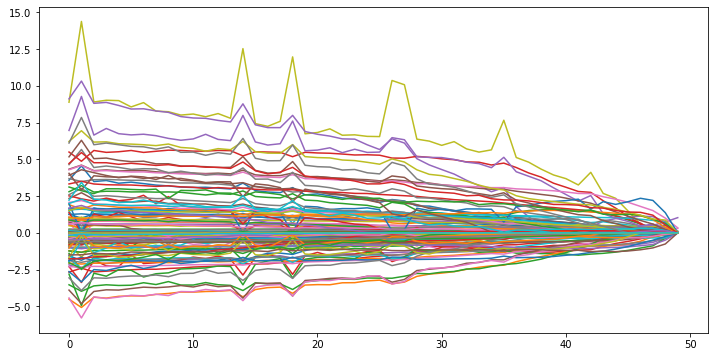

In [80]:
coefs_df_l1 = get_reg_coefs(X_train_scaled, y_train, X_train.columns, penalty="l1")
plot_reg_coefs(coefs_df_l1)

у нас есть множество переменных, коэффициенты которых были на всех диапазонах нулевые коэффициенты

In [81]:
to_del = coefs_df_l1.mean()[coefs_df_l1.mean()==0].index

In [82]:
exp_name='remove meaningless features'
data = df.drop(columns=to_del).fillna(0)
assess_data(data,df_quality, exp_name, verbose=True)

Train_shape: (42000, 143) Test shape: (18000, 143)

=== Quality Report ===
Accuracy: 	 0.991
Precision: 	 0.647
Recall: 	 0.752
f1_score: 	 0.695
ROC-AUC: 	 0.873



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873


удивительно, но стало хуже, чем baseline. попробуем срезы лучших переменных

In [120]:
def get_important_features_v2(coefs, n_feats_limit):
    selected=[]
    level=coefs.shape[0]-1
    while True:
        # берем строчку текущего уровня
        coefs_on_current_level = coefs.iloc[level,:]
#         убираем нулевые коэффициенты
        coefs_on_current_level = coefs_on_current_level[coefs_on_current_level!=0]
#     убираем уже ранее выбранные переменные
        coefs_on_current_level = coefs_on_current_level[~coefs_on_current_level.index.isin(selected)]
# считаем, сколько нужно еще переменных выбрать
        coefs_left = n_feats_limit - len(selected)
# добираем лучшие коэффициенты с текущего уровня    
        selected = selected + coefs_on_current_level.sort_values().tail(coefs_left).index.to_list()
        if len(selected)>=n_feats_limit:
            return selected
        level = level -1

In [126]:
exp_name='top 10 best'
data = df[get_important_features_v2(coefs_df_l1, 10)+['class']].fillna(0)
assess_data(data,df_quality, exp_name, verbose=False)
exp_name='top 50 best'
data = df[get_important_features_v2(coefs_df_l1, 50)+['class']].fillna(0)
assess_data(data,df_quality, exp_name, verbose=False)
exp_name='top 100 best'
data = df[get_important_features_v2(coefs_df_l1, 100)+['class']].fillna(0)
assess_data(data,df_quality, exp_name, verbose=False)

Train_shape: (42000, 10) Test shape: (18000, 10)
Train_shape: (42000, 50) Test shape: (18000, 50)
Train_shape: (42000, 100) Test shape: (18000, 100)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861


## Визуализируем наиболее значимые фичи

Wall time: 15.4 s


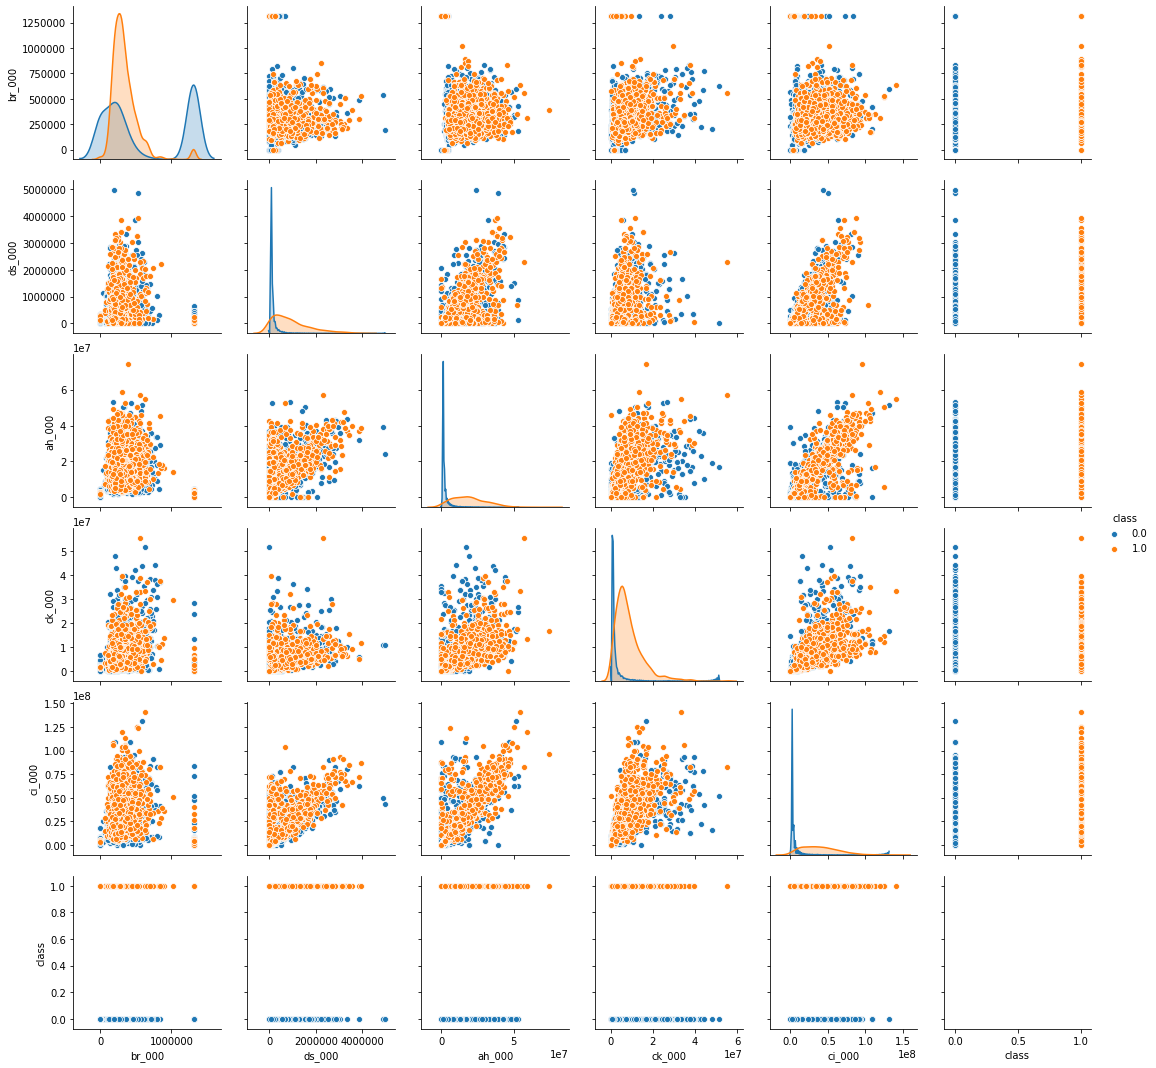

In [132]:
%%time
sns.pairplot(df[get_important_features_v2(coefs_df_l1, 5)+['class']], hue='class')

# Попробуем поработать с аутлаерами

In [159]:
def outlier_detect_IQR(data, col, threshold=3):    
    IQR = data[col].quantile(0.95) - data[col].quantile(0.05)
    Lower_fence = data[col].quantile(0.05) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.95) + (IQR * threshold)
    borders = (Lower_fence, Upper_fence)
    return borders

def outlier_detect_mean_std(data, col, threshold=3):
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    borders = (Lower_fence, Upper_fence)
    return borders

def windsorization(data, cols, borders_type="std", strategy='both'):
    data_copy = data.copy(deep=True)  
    for col in cols:
        if borders_type=="std":
            borders = outlier_detect_mean_std(data, col, threshold=3)
        elif borders_type=="iqr":
            borders = outlier_detect_IQR(data, col, threshold=3)
        
        if strategy == 'both':
            data_copy.loc[data_copy[col]>borders[1], col] = borders[1]
            data_copy.loc[data_copy[col]<borders[0], col] = borders[0]
        elif strategy == 'top':
            data_copy.loc[data_copy[col]>borders[1], col] = borders[1]
        elif strategy == 'bottom':
            data_copy.loc[data_copy[col]<borders[0], col] = borders[0]  
    return data_copy

In [162]:
exp_name='impute most_frequent + STD_outliers'
imp = SimpleImputer(strategy='most_frequent')
tmp = pd.DataFrame (imp.fit_transform(df), columns=df.columns)
data_STD_outliers = windsorization(
    tmp, cols=get_important_features_v2(coefs_df_l1, 100), borders_type="std", strategy='both')

assess_data(data_STD_outliers,df_quality, exp_name, verbose=False)

exp_name='impute most_frequent + IQR_outliers'
imp = SimpleImputer(strategy='most_frequent')
tmp = pd.DataFrame (imp.fit_transform(df), columns=df.columns)
data_IQR_outliers = windsorization(
    tmp, cols=get_important_features_v2(coefs_df_l1, 100), borders_type="iqr", strategy='both')
assess_data(data_IQR_outliers,df_quality, exp_name, verbose=False)

Train_shape: (42000, 170) Test shape: (18000, 170)
Train_shape: (42000, 170) Test shape: (18000, 170)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861
impute most_frequent+indicators,0.991,0.657,0.779,0.712,0.886


In [175]:
def asses_data_wo_splitting(X_train_scaled, X_test_scaled,
                            y_train, y_test,
                            df_quality, exp_name, verbose=True):
    
    model_LogR = LogisticRegression(solver="liblinear")
    model_LogR.fit(X_train_scaled, y_train)
    pred = model_LogR.predict(X_test_scaled)

    quality_list = quality_report(pred, y_test.values, verbose=verbose)
    
    df_quality.loc[exp_name, :] = quality_list
    
    return df_quality.round(3)

In [177]:
exp_name='impute most_frequent + STD_outliers+RandomOverSampler'
imp = SimpleImputer(strategy='most_frequent')
tmp = pd.DataFrame (imp.fit_transform(df), columns=df.columns)
data_STD_outliers = windsorization(
    tmp, cols=get_important_features_v2(coefs_df_l1, 100), borders_type="std", strategy='both')

X_train, X_test, y_train, y_test = data_split_train_test(data_STD_outliers)
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)


from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

asses_data_wo_splitting(X_resampled, X_test_scaled, y_resampled, y_test, df_quality,exp_name)

Train_shape: (42000, 170) Test shape: (18000, 170)

=== Quality Report ===
Accuracy: 	 0.972
Precision: 	 0.910
Recall: 	 0.360
f1_score: 	 0.516
ROC-AUC: 	 0.679



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861
impute most_frequent+indicators,0.991,0.657,0.779,0.712,0.886


In [165]:
from imblearn.over_sampling import SMOTE, ADASYN

In [182]:
exp_name='impute most_frequent + STD_outliers+SMOTE'
imp = SimpleImputer(strategy='most_frequent')
tmp = pd.DataFrame (imp.fit_transform(df), columns=df.columns)
data_STD_outliers = windsorization(
    tmp, cols=get_important_features_v2(coefs_df_l1, 100), borders_type="std", strategy='both')

X_train, X_test, y_train, y_test = data_split_train_test(data_STD_outliers)
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

X_resampled, y_resampled = SMOTE().fit_resample(X_train_scaled, y_train)

asses_data_wo_splitting(X_resampled, X_test_scaled, y_resampled, y_test, df_quality,exp_name)

Train_shape: (42000, 170) Test shape: (18000, 170)

=== Quality Report ===
Accuracy: 	 0.973
Precision: 	 0.897
Recall: 	 0.372
f1_score: 	 0.526
ROC-AUC: 	 0.685



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861
impute most_frequent+indicators,0.991,0.657,0.779,0.712,0.886


In [183]:
exp_name='impute most_frequent + STD_outliers+ADASYN'
imp = SimpleImputer(strategy='most_frequent')
tmp = pd.DataFrame (imp.fit_transform(df), columns=df.columns)
data_STD_outliers = windsorization(
    tmp, cols=get_important_features_v2(coefs_df_l1, 100), borders_type="std", strategy='both')

X_train, X_test, y_train, y_test = data_split_train_test(data_STD_outliers)
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

X_resampled, y_resampled = ADASYN().fit_resample(X_train_scaled, y_train)

asses_data_wo_splitting(X_resampled, X_test_scaled, y_resampled, y_test, df_quality,exp_name)

Train_shape: (42000, 170) Test shape: (18000, 170)

=== Quality Report ===
Accuracy: 	 0.963
Precision: 	 0.903
Recall: 	 0.299
f1_score: 	 0.449
ROC-AUC: 	 0.649



,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861
impute most_frequent+indicators,0.991,0.657,0.779,0.712,0.886


In [186]:
from sklearn.impute import MissingIndicator
indicator = MissingIndicator()
indicator.fit(df)

MissingIndicator(error_on_new=True, features='missing-only', missing_values=nan,
                 sparse='auto')

In [188]:
indicator.transform(df).shape

(60000, 169)

In [189]:
df.shape

(60000, 171)

In [197]:
exp_name='impute most_frequent + IQR_outliers+indicators'
from sklearn.impute import MissingIndicator
imp = SimpleImputer(strategy='most_frequent')
indicator = MissingIndicator()
indicator.fit(df)
tmp = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
# tmp = pd.concat([pd.DataFrame(imp.fit_transform(df.drop(columns='class'))), df['class']], axis=1)
data_IQR_outliers = windsorization(
    tmp, cols=get_important_features_v2(coefs_df_l1, 100), borders_type="iqr", strategy='both')

data_with_ind = pd.concat([data_IQR_outliers, pd.DataFrame(indicator.transform(df)*1)], axis=1)
assess_data(data_with_ind,df_quality, exp_name, verbose=False)

Train_shape: (42000, 339) Test shape: (18000, 339)


,Accuracy,Precision,Recall,F1,ROC-AUC
baseline,0.991,0.660,0.762,0.707,0.878
remove correlated,0.990,0.617,0.768,0.684,0.881
impute mean,0.990,0.617,0.768,0.684,0.881
impute most_frequent,0.991,0.633,0.772,0.696,0.883
impute KNN,0.991,0.677,0.775,0.722,0.885
remove meaningless features,0.991,0.647,0.752,0.695,0.873
top 10 best,0.985,0.387,0.580,0.464,0.785
top 50 best,0.989,0.563,0.725,0.634,0.859
top 100 best,0.990,0.617,0.728,0.668,0.861
impute most_frequent+indicators,0.991,0.657,0.779,0.712,0.886
